In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn.functional as F
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from memit import compute_z, get_target_new_avg_prob, get_context_templates, MEMITHyperParams
from memit.compute_z import get_module_input_output_at_words
from util import nethook
from experiments.py.eval_utils_counterfact import compute_rewrite_quality_counterfact
import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from dsets import (
    AttributeSnippets,
    CounterFactDataset,
    MENDQADataset,
    MultiCounterFactDataset,
    get_tfidf_vectorizer,
    KnownsDataset,
)
from tqdm import tqdm

from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

/home/hello/miniconda3/envs/swea/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparation

In [2]:
# model_path = "/science/llms/"
# model_name = "Meta-Llama-3-8B-Instruct"
# params_path = "./hparams/MEMIT/Llama3-8B.json"

# model_path = "../ptms/"
# model_name = "EleutherAI/gpt-j-6B"
# params_path = "./hparams/MEMIT/EleutherAI_gpt-j-6B.json"

model_path = "/science/llms/"
model_name = "gpt2-xl"
params_path = "./hparams/MEMIT/gpt2-xl.json"

DATA_DIR = "./data"
hparams = MEMITHyperParams.from_json(params_path)
mcf_data = MultiCounterFactDataset(DATA_DIR, size = 200)
requests = [
            {"case_id": record["case_id"], **record["requested_rewrite"]}
            for record in mcf_data
            ]

for i, request in enumerate(requests):
    if request["target_new"]["str"][0] != " ":
        # Space required for correct tokenization
        requests[i]["target_new"]["str"] = " " + request["target_new"]["str"]

z_layer = hparams.layers[-1]
v_loss_layer = hparams.v_loss_layer

Loaded dataset with 200 elements


In [3]:
if model_path:
    model = AutoModelForCausalLM.from_pretrained(model_path + model_name).cuda()
    tok = AutoTokenizer.from_pretrained(model_path + model_name) 
else:
    model = AutoModelForCausalLM.from_pretrained(model_name).cuda()
    tok = AutoTokenizer.from_pretrained(model_name) 
tok.pad_token = tok.eos_token

CONTEXT_TEMPLATES = get_context_templates(model, tok)

Cached context templates [['{}'], ['The first two weeks of this year have seen a. {}', 'Therefore, if a person who has been given a. {}', 'Because of the high cost of housing, it is. {}', "I don't have to worry about that, because. {}", "You're not alone, you're not alone,. {}"]]


### Computing z

In [10]:
verbose = False

scores_distributed = {layer: [] for layer in hparams.layers}
scores_computed = {layer: [] for layer in hparams.layers}
for request in tqdm(requests, total=(len(requests))):
    initial_avg_probs = get_target_new_avg_prob(model, tok, request, hparams, 1, CONTEXT_TEMPLATES, verbose=verbose)
    if verbose:
        print(f"Initial target new: {request['target_new']['str']} avg probs: {initial_avg_probs}")
    _, delta = compute_z(
        model,
        tok,
        request,
        hparams,
        z_layer,
        CONTEXT_TEMPLATES,
        return_delta = True,
        verbose=verbose
    )
    for i, layer in enumerate(hparams.layers):
        avg_probs = get_target_new_avg_prob(model, tok, request, hparams, layer, CONTEXT_TEMPLATES, delta / (len(hparams.layers) - i),verbose=verbose)
        if verbose:
            print(f"Layer: {layer}. Delta = Delta / ({len(hparams.layers) - i}). Target new: {request['target_new']['str']} avg probs: {avg_probs}")
        scores_distributed[layer].append(avg_probs - initial_avg_probs)
        if layer == z_layer:
            delta_computed = delta
        else:
            _, delta_computed = compute_z(
                model,
                tok,
                request,
                hparams,
                layer,
                CONTEXT_TEMPLATES,
                return_delta = True,
                verbose=verbose
            )
        avg_probs_computed = get_target_new_avg_prob(model, tok, request, hparams, layer, CONTEXT_TEMPLATES, delta_computed,verbose=verbose)
        if verbose:
            print(f"Layer: {layer}. Computed Delta. Target new: {request['target_new']['str']} avg probs: {avg_probs}")
        scores_computed[layer].append(avg_probs_computed - initial_avg_probs)

scores_computed_file = f"./pkls/scores_computed_{model_name.replace('/', '_')}.pkl"
scores_distributed_file = f"./pkls/scores_distributed_{model_name.replace('/', '_')}.pkl"
# 存储数据
with open(scores_computed_file, 'wb') as f:
    pickle.dump(scores_computed, f)

with open(scores_distributed_file, 'wb') as f:
    pickle.dump(scores_distributed, f)


100%|██████████| 200/200 [37:00<00:00, 11.10s/it]


In [43]:
scores_computed_file = f"./pkls/scores_computed_Meta-Llama-3-8B-Instruct.pkl"
scores_distributed_file = f"./pkls/scores_distributed_Meta-Llama-3-8B-Instruct.pkl"

# 读取数据
with open(scores_computed_file, 'rb') as f:
    scores_computed1 = pickle.load(f)

with open(scores_distributed_file, 'rb') as f:
    scores_distributed1 = pickle.load(f)

# 数据处理
layers = list(scores_distributed1.keys())
means_distributed1 = [np.mean(values) for values in scores_distributed1.values()]
means_computed1 = [np.mean(values) for values in scores_computed1.values()]

# 倒序处理
layers = layers[::-1]
means_distributed1 = means_distributed1[::-1]
means_computed1 = means_computed1[::-1]

scores_computed_file = f"./pkls/scores_computed_EleutherAI_gpt-j-6B.pkl"
scores_distributed_file = f"./pkls/scores_distributed_EleutherAI_gpt-j-6B.pkl"

# 读取数据
with open(scores_computed_file, 'rb') as f:
    scores_computed2 = pickle.load(f)

with open(scores_distributed_file, 'rb') as f:
    scores_distributed2 = pickle.load(f)

# 数据处理
layers = list(scores_distributed2.keys())
means_distributed2 = [np.mean(values) for values in scores_distributed2.values()]
means_computed2 = [np.mean(values) for values in scores_computed2.values()]

# 倒序处理
layers = layers[::-1]
means_distributed2 = means_distributed2[::-1]
means_computed2 = means_computed2[::-1]

scores_computed_file = f"./pkls/scores_computed_gpt2-xl.pkl"
scores_distributed_file = f"./pkls/scores_distributed_gpt2-xl.pkl"

# 读取数据
with open(scores_computed_file, 'rb') as f:
    scores_computed3 = pickle.load(f)

with open(scores_distributed_file, 'rb') as f:
    scores_distributed3 = pickle.load(f)

# 数据处理
layers = list(scores_distributed.keys())
means_distributed3 = [np.mean(values) for values in scores_distributed3.values()]
means_computed3 = [np.mean(values) for values in scores_computed3.values()]

# 倒序处理
layers = layers[::-1]
means_distributed3 = means_distributed3[::-1]
means_computed3 = means_computed3[::-1]

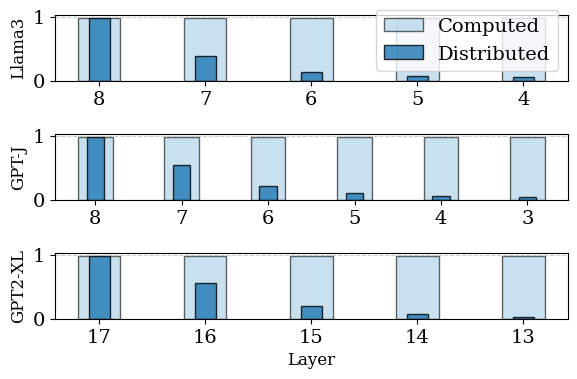

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 示例数据

means_distributed1 = [np.mean(values) for values in scores_distributed1.values()]
means_computed1 = [np.mean(values) for values in scores_computed1.values()]

means_distributed2 = [np.mean(values) for values in scores_distributed2.values()]
means_computed2 = [np.mean(values) for values in scores_computed2.values()]

means_distributed3 = [np.mean(values) for values in scores_distributed3.values()]
means_computed3 = [np.mean(values) for values in scores_computed3.values()]


means_distributed1 = means_distributed1[::-1]
means_computed1 = means_computed1[::-1]
means_distributed2 = means_distributed2[::-1]
means_computed2 = means_computed2[::-1]
means_distributed3 = means_distributed3[::-1]
means_computed3 = means_computed3[::-1]

# 绘制重叠柱状图，宽度不同

bar_width_distributed = 0.2  # Distributed柱宽
bar_width_computed = 0.4  # Computed柱宽

# 使用Seaborn配色方案
colors = sns.color_palette("Paired", 2)

# 创建3个子图（1列3行）
fig, axes = plt.subplots(3, 1, figsize=(6, 4))
layers = list(scores_distributed1.keys())
layers = layers[::-1]
x = np.arange(len(layers))  # X轴位置
# 绘制第一个子图
axes[0].bar(x , means_computed1, bar_width_computed, label='Computed', color=colors[0], edgecolor='black', alpha=0.6)
axes[0].bar(x , means_distributed1, bar_width_distributed, label='Distributed', color=colors[1], edgecolor='black', alpha=0.8)


axes[0].set_ylabel('Llama3', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(layers)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
axes[0].legend(loc='best')

layers = list(scores_distributed2.keys())
layers = layers[::-1]
x = np.arange(len(layers))  # X轴位置
# 绘制第二个子图
axes[1].bar(x, means_computed2, bar_width_computed, label='Computed 2', color=colors[0], edgecolor='black', alpha=0.6)
axes[1].bar(x, means_distributed2, bar_width_distributed, label='Distributed 2', color=colors[1], edgecolor='black', alpha=0.8)


axes[1].set_ylabel('GPT-J', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(layers)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)


# 绘制第三个子图
layers = list(scores_distributed3.keys())
layers = layers[::-1]
x = np.arange(len(layers))  # X轴位置
axes[2].bar(x , means_computed3, bar_width_computed, label='Computed 3', color=colors[0], edgecolor='black', alpha=0.6)
axes[2].bar(x , means_distributed3, bar_width_distributed, label='Distributed 3', color=colors[1], edgecolor='black', alpha=0.8)

axes[2].set_xlabel('Layer', fontsize=12)
axes[2].set_ylabel('GPT2-XL', fontsize=12)
axes[2].set_xticks(x)
axes[2].set_xticklabels(layers)
axes[2].grid(axis='y', linestyle='--', alpha=0.6)
# fig.text(0.0, 0.5, 'Average Contribution Score', va='center', rotation='vertical')

# 自动调整子图间距
plt.tight_layout()

# 保存图像
plt.savefig("./figs/avg-contri-score-overlap-different-width.pdf")

# 显示图像
# plt.show()


### Editing performance

/tmp/ipykernel_2502700/2769253161.py:124: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  line = plt.plot(plot_angles, plot_data, 'o-', linewidth=1.5,


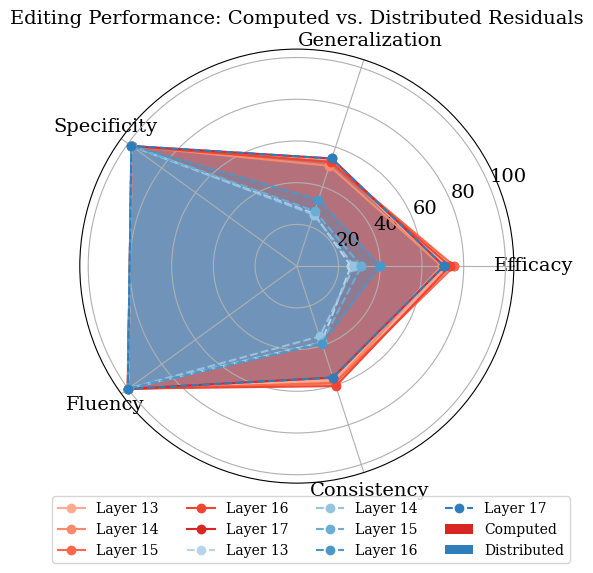

: 

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 数据准备
labels = ["Efficacy","Generalization","Specificity", "Fluency",  "Consistency"]
layers1 = [4, 5, 6, 7, 8]
original_flu1 = 629.10
# original_consis=23.55
original_spe1=88.95
data_computed1 = [
    [93.5, 83.75 , 88.5 / original_spe1 * 100, 628.15 / original_flu1 * 100, 29.81],
    [93.0, 77.0 , 88.3 / original_spe1 * 100, 627.66 / original_flu1 * 100, 29.45],
    [86.5, 73.0 , 88.05 / original_spe1 * 100, 628.41 / original_flu1 * 100, 28.59],
    [86.5, 64.25 , 88.15 / original_spe1 * 100, 627.89 / original_flu1 * 100, 28.06],
    [77.5, 52.5 , 88.15 / original_spe1 * 100, 627.73 / original_flu1 * 100, 26.9],
]

data_distributed1 = [
    [18.5, 15.25 , 88.8 / original_spe1 * 100, 629.04 / original_flu1 * 100, 23.91],
    [19.5, 17.25 , 88.85 / original_spe1 * 100, 629.04 / original_flu1 * 100, 23.76],
    [24.0, 17.75, 89.0 / original_spe1 * 100, 628.36 / original_flu1 * 100, 23.65],
    [29.5, 22.25, 89.1 / original_spe1 * 100, 629.14 / original_flu1 * 100, 23.79],
    [77.5, 52.5, 88.15 / original_spe1 * 100, 627.73 / original_flu1 * 100, 26.9],
]

layers2 = [3, 4, 5, 6, 7, 8]
original_flu2 = 621.8
# original_consis=23.55
original_spe2=83.11
data_computed2 = [
    [97.5, 87.51 , 82.55 / original_spe2 * 100, 621.41 / original_flu2 * 100, 40.13],
    [98.5, 87.0 , 82.25 / original_spe2 * 100, 622.77 / original_flu2 * 100, 40.12],
    [98.0, 85.25 , 81.75 / original_spe2 * 100, 621.96 / original_flu2 * 100, 39.62],
    [99.0, 82.25 , 80.90 / original_spe2 * 100, 622.58 / original_flu2 * 100, 39.47],
    [96.50, 75.75 , 81.50 / original_spe2 * 100, 621.25 / original_flu2 * 100, 38.37],
    [89.0, 67.0 , 81.30 / original_spe2 * 100, 621.43 / original_flu2 * 100, 35.42],
]

data_distributed2 = [
    [30.0, 29.0 , 82.85 / original_spe2 * 100, 620.99 / original_flu2 * 100, 29.55],
    [31.0, 29.25 , 82.85 / original_spe2 * 100, 622.32 / original_flu2 * 100, 29.74],
    [39.5, 33.5, 83.0 / original_spe2 * 100, 621.81 / original_flu2 * 100, 29.64],
    [46.5, 37.0, 82.5 / original_spe2 * 100, 621.03 / original_flu2 * 100, 30.39],
    [61.50, 49.0, 82.8 / original_spe2 * 100, 621.51 / original_flu2 * 100, 31.49],
    [89.0, 67.0 , 81.30 / original_spe2 * 100, 621.43 / original_flu2 * 100, 35.42],
]

layers3 = [13,14,15,16,17]
original_flu3 = 626.64
# original_consis=23.55
original_spe3=78.53
data_computed3 = [
    [69.5, 53.75 , 76.65 / original_spe3 * 100, 627.43 / original_flu3 * 100, 34.11],
    [69.5, 50.57 , 76.8 / original_spe3 * 100, 626.6 / original_flu3 * 100, 34.42],
    [75.5, 52.5 , 76.8 / original_spe3 * 100, 628.62 / original_flu3 * 100, 34.37],
    [73.5, 52.5 , 76.75 / original_spe3 * 100, 625.76 / original_flu3 * 100, 34.66],
    [70.5, 54.25 , 76.95 / original_spe3 * 100, 627.55 / original_flu3 * 100, 33.85],
]

data_distributed3 = [
    [26.0, 26.5 , 76.95 / original_spe3 * 100, 625.54 / original_flu3 * 100, 30.52],
    [27.5, 26.0 , 76.95 / original_spe3 * 100, 626.19 / original_flu3 * 100, 29.95],
    [31.0, 27.75, 76.70 / original_spe3 * 100, 626.31 / original_flu3 * 100, 30.56],
    [40.0, 33.5, 77.05 / original_spe3 * 100, 626.38 / original_flu3 * 100, 30.63],
    [70.5, 54.25 , 76.95 / original_spe3 * 100, 627.55 / original_flu3 * 100, 33.85],
]


# Z分数归一化函数
def normalize_zscore(data):
    normalized_data = []
    for i in range(len(labels)):
        column = [row[i] for row in data]
        if i!= 4:
            normalized_data.append(column)
        else:
            mean = np.mean(column)
            std = np.std(column)
            normalized_column = [(((x - mean) / std)*10 +50 ) for x in column]
            normalized_data.append(normalized_column)
    return np.array(normalized_data).T

# 归一化数据
normalized = normalize_zscore(data_computed3 + data_distributed3)
layers = layers3
normalized_computed = normalized[:len(layers)]
normalized_distributed = normalized[len(layers):]
# normalized_computed = data_computed
# normalized_distributed = data_distributed
# 创建图形
plt.figure(figsize=(8, 6))
plt.subplot(projection='polar')

# 创建自定义图例的元素
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 角度和颜色设置
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
red_colors = [plt.cm.Reds(0.3 + 0.1 * i) for i in range(len(layers))]
blue_colors = [plt.cm.Blues(0.3 + 0.1 * i) for i in range(len(layers))]

# 用于图例的列表
legend_elements = []

# 绘制Computed数据
for i in range(len(layers)):
    plot_data = np.concatenate((normalized_computed[i], [normalized_computed[i][0]]))
    plot_angles = np.concatenate((angles, [angles[0]]))
    line = plt.plot(plot_angles, plot_data, 'o-', linewidth=1.5, color=red_colors[i], 
                    label=f'Layer {layers[i]}')
    plt.fill(plot_angles, plot_data, alpha=0.3, color=red_colors[i])
    
    # 为每个Computed图层创建图例元素
    legend_elements.append(
        Line2D([0], [0], color=red_colors[i], marker='o',lw=1.5, 
               label=f'Layer {layers[i]}')
    )

# 绘制Distributed数据
for i in range(len(layers)):
    plot_data = np.concatenate((normalized_distributed[i], [normalized_distributed[i][0]]))
    plot_angles = np.concatenate((angles, [angles[0]]))
    line = plt.plot(plot_angles, plot_data, 'o-', linewidth=1.5, 
                    color=blue_colors[i], linestyle='--', 
                    label=f'Layer {layers[i]}')
    plt.fill(plot_angles, plot_data, alpha=0.3, color=blue_colors[i])
    
    # 为每个Distributed图层创建图例元素
    legend_elements.append(
        Line2D([0], [0], color=blue_colors[i], lw=1.5, linestyle='--', marker='o', 
               label=f'Layer {layers[i]}'))

# 添加数据类型和填充的图例元素
legend_elements.extend([
    Patch(facecolor=red_colors[-1], label='Computed'),
    Patch(facecolor=blue_colors[-1], label='Distributed')
])

plt.title('Editing Performance: Computed vs. Distributed Residuals', fontsize=14)
plt.thetagrids(angles * 180/np.pi, labels)

# 使用自定义图例元素
plt.legend(handles=legend_elements, loc='lower left', ncol=4, fontsize=10,bbox_to_anchor=(-0.08, -0.2))

plt.grid(True)
plt.tight_layout()
plt.savefig("./figs/GPT2-mcf-performance-compare.pdf")


### Compare Delta

In [4]:
verbose = False
layer_delta_dict = {layer: [] for layer in hparams.layers}
cos_similarities = {layer: [] for layer in hparams.layers[:-1]}
norms = {layer: [] for layer in hparams.layers[:-1]}
for request in tqdm(requests, total=(len(requests))):
    z_layer_target, z_layer_delta = compute_z(
        model,
        tok,
        request,
        hparams,
        z_layer,
        CONTEXT_TEMPLATES,
        return_delta = True,
        verbose=verbose
    )
    layer_delta_dict[z_layer].append((z_layer_target.cpu().detach().numpy(), z_layer_delta.cpu().detach().numpy()))
    for i, layer in enumerate(hparams.layers[:-1]):
        layer_target, layer_delta = compute_z(
                model,
                tok,
                request,
                hparams,
                layer,
                CONTEXT_TEMPLATES,
                return_delta = True,
                verbose=verbose,
            )
        layer_delta_dict[layer].append((layer_target.cpu().detach().numpy(), layer_delta.cpu().detach().numpy()))
        cos_sim = torch.nn.functional.cosine_similarity(z_layer_delta / (len(hparams.layers) - i), layer_delta, dim=0)
        norm = torch.linalg.norm(layer_target - z_layer_target)
        if verbose:
            print(f"Layer: {layer}. Delta similarity: {cos_sim}")
        cos_similarities[layer].append(cos_sim.item())
        norms[layer].append(norm.item())

cos_similarities_file = f"./pkls/cos_similarities_{model_name.replace('/', '_')}.pkl"
norms_file = f"./pkls/norms_{model_name.replace('/', '_')}.pkl"
layer_delta_dict_file = f"./pkls/layer_delta_dict_{model_name.replace('/', '_')}.pkl"
# 存储数据
with open(cos_similarities_file, 'wb') as f:
    pickle.dump(cos_similarities, f)

with open(norms_file, 'wb') as f:
    pickle.dump(norms, f)

with open(layer_delta_dict_file, 'wb') as f:
    pickle.dump(layer_delta_dict, f)

100%|██████████| 200/200 [24:05<00:00,  7.23s/it]


### Plot cosine similarity

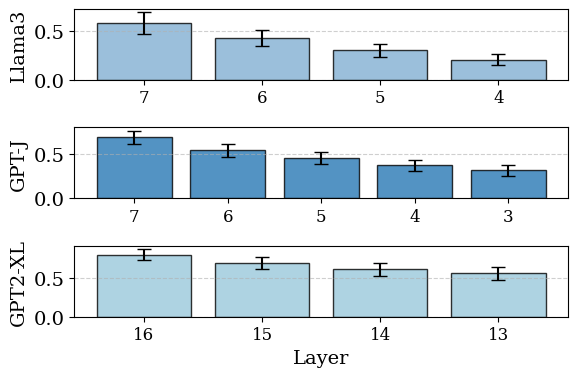

In [9]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    cosine_sim = dot_product / (norm_A * norm_B)
    return cosine_sim
# colors = sns.color_palette("Accent", 3)
colors = ["#82B0D2", "#2878b5", "#9ac9db"]
llms = ['Meta-Llama-3-8B-Instruct', 'EleutherAI_gpt-j-6B','gpt2-xl']
llms_hparams = ['Llama3-8B', 'EleutherAI_gpt-j-6B', 'gpt2-xl']
llms_label = ['Llama3', 'GPT-J', 'GPT2-XL']
fig, axes = plt.subplots(3, 1, figsize=(6, 4))
for i, llm in enumerate(llms):
    layer_delta_dict_file = f"./pkls/layer_delta_dict_{llm}.pkl"
    with open(layer_delta_dict_file, 'rb') as f:
        layer_delta_dict = pickle.load(f)
    hparams = MEMITHyperParams.from_json(f"./hparams/MEMIT/{llms_hparams[i]}.json")
    layers = hparams.layers
    cos_similarities = {layer: [] for layer in layers[:-1]}
    data_len = len(layer_delta_dict[layers[-1]])
    for j in range(data_len):
        last_layer_delta = layer_delta_dict[layers[-1]][j][1]
        for k, layer in enumerate(layers[:-1]):
            layer_delta = layer_delta_dict[layer][j][1]
            cos_similarities[layer].append(cosine_similarity(last_layer_delta / (len(hparams.layers) - k), layer_delta))

    means = [np.mean(values) for values in cos_similarities.values()]
    errors = [np.std(values) for values in cos_similarities.values()]  # 误差为标准差

    # 倒序处理
    layers = layers[::-1]
    means = means[::-1]
    errors = errors[::-1]

    # 绘制带误差条的柱状图
    axes[i].bar(range(len(layers)-1), means, yerr=errors, capsize=5, color=colors[i], edgecolor='black', alpha=0.8)

    if i==2:
        axes[i].set_xlabel('Layer', fontsize=14)
    axes[i].set_ylabel(llms_label[i], fontsize=14)
    axes[i].set_xticks(range(len(layers)-1))
    axes[i].set_xticklabels(layers[1:], fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)


# 自动调整子图间距
plt.tight_layout()

# 显示图像
plt.savefig('./figs/cos-sims.pdf')
            


In [7]:
cos_similarities_file = f"./pkls/cos_similarities_{model_name.replace('/', '_')}.pkl"
norms_file = f"./pkls/norms_{model_name.replace('/', '_')}.pkl"
layer_delta_dict_file = f"./pkls/layer_delta_dict_{model_name.replace('/', '_')}.pkl"

# 读取数据
with open(cos_similarities_file, 'rb') as f:
    cos_similarities = pickle.load(f)

with open(norms_file, 'rb') as f:
    norms = pickle.load(f)

with open(layer_delta_dict_file, 'rb') as f:
    layer_delta_dict = pickle.load(f)

NameError: name 'model_name' is not defined

In [16]:
cos_similarities = {layer: [] for layer in hparams.layers[:-1]}
distribute_norms = {layer: [] for layer in hparams.layers[:-1]}
direct_norms = {layer: [] for layer in hparams.layers[:-1]}

def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    cosine_sim = dot_product / (norm_A * norm_B)
    return cosine_sim

data_len = len(layer_delta_dict[hparams.layers[-1]])
for j in range(data_len):
    last_layer_delta = layer_delta_dict[hparams.layers[-1]][j][1]
    for i, layer in enumerate(hparams.layers[:-1]):
        layer_delta = layer_delta_dict[layer][j][1]
        cos_similarities[layer].append(cosine_similarity(last_layer_delta / (len(hparams.layers) - i), layer_delta))
        distribute_norms[layer].append(np.linalg.norm((last_layer_delta / (len(hparams.layers) - i) - layer_delta)))
        direct_norms[layer].append(np.linalg.norm(layer_delta - last_layer_delta))

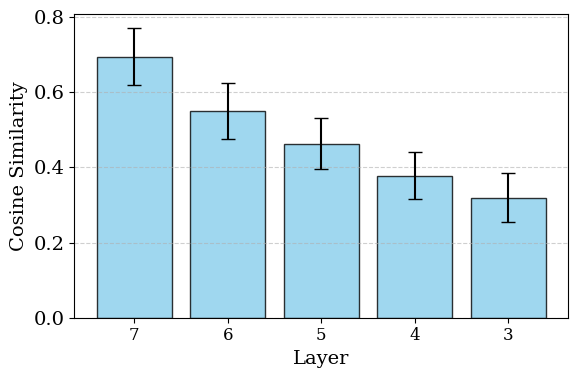

In [17]:

plt.figure(figsize=(6, 4))  # 设置图大小 (宽, 高)
plt.rcParams.update({'font.size': 14})  # 全局字体大小

layers = list(cos_similarities.keys())
means = [np.mean(values) for values in cos_similarities.values()]
errors = [np.std(values) for values in cos_similarities.values()]  # 误差为标准差

layers = layers[::-1]
means = means[::-1]
errors = errors[::-1]


# 绘制带误差条的柱状图
plt.bar(range(0,len(layers)), means, yerr=errors, capsize=5, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
# plt.title('Average Contribution Score with Error Bars')
plt.xticks(range(0,len(layers)), labels=layers, fontsize=12)  # 设置x轴刻度
plt.grid(axis='y', linestyle='--', alpha=0.6)  # 添加水平网格线
plt.tight_layout()
# plt.savefig("./figs/Llama3-mcf-cos-sim.pdf")
plt.show()

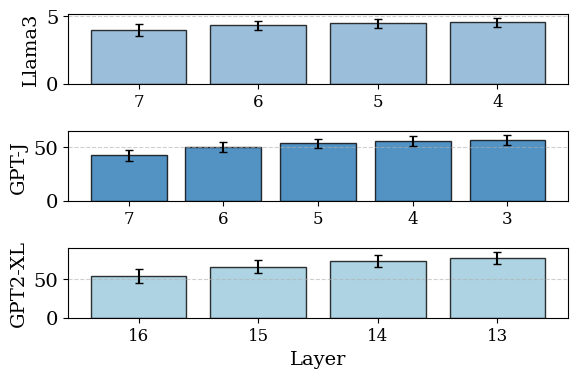

In [10]:

colors = sns.color_palette("bright", 6)
llms = ['Meta-Llama-3-8B-Instruct', 'EleutherAI_gpt-j-6B','gpt2-xl']
llms_hparams = ['Llama3-8B', 'EleutherAI_gpt-j-6B', 'gpt2-xl']
llms_label = ['Llama3', 'GPT-J', 'GPT2-XL']
colors = ["#82B0D2", "#2878b5", "#9ac9db"]
fig, axes = plt.subplots(3, 1, figsize=(6, 4))
for i, llm in enumerate(llms):
    layer_delta_dict_file = f"./pkls/layer_delta_dict_{llm}.pkl"
    with open(layer_delta_dict_file, 'rb') as f:
        layer_delta_dict = pickle.load(f)
    hparams = MEMITHyperParams.from_json(f"./hparams/MEMIT/{llms_hparams[i]}.json")
    layers = hparams.layers
    direct_norms = {layer: [] for layer in hparams.layers[:-1]}
    data_len = len(layer_delta_dict[layers[-1]])
    for j in range(data_len):
        last_layer_delta = layer_delta_dict[layers[-1]][j][1]
        for k, layer in enumerate(layers[:-1]):
            layer_delta = layer_delta_dict[layer][j][1]
            direct_norms[layer].append(np.linalg.norm(layer_delta - last_layer_delta))

    means = [np.mean(values) for values in direct_norms.values()]
    errors = [np.std(values) for values in direct_norms.values()]  # 误差为标准差

    # 倒序处理
    layers = layers[::-1]
    means = means[::-1]
    errors = errors[::-1]

    # 绘制带误差条的柱状图
    axes[i].bar(range(len(layers)-1), means, yerr=errors, capsize=3, color=colors[i], edgecolor='black', alpha=0.8)

    if i==2:
        axes[i].set_xlabel('Layer', fontsize=14)
    axes[i].set_ylabel(llms_label[i], fontsize=14)
    axes[i].set_xticks(range(len(layers)-1))
    axes[i].set_xticklabels(layers[1:], fontsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)


# 自动调整子图间距
plt.tight_layout()

# 显示图像
plt.savefig("./figs/mcf-direct-norms-diff.pdf")
# plt.show()
            


# plt.figure(figsize=(6, 4))  # 设置图大小 (宽, 高)
# plt.rcParams.update({'font.size': 14})  # 全局字体大小

# layers = list(direct_norms.keys())
# means = [np.mean(values) for values in direct_norms.values()]
# errors = [np.std(values) for values in direct_norms.values()]  # 误差为标准差

# layers = layers[::-1]
# means = means[::-1]
# errors = errors[::-1]


# # 绘制带误差条的柱状图
# plt.bar(range(0,len(layers)), means, yerr=errors, capsize=5, color='skyblue', edgecolor='black', alpha=0.8)
# plt.xlabel('Layer', fontsize=14)
# plt.ylabel('Norm of Differences', fontsize=14)
# # plt.title('Average Contribution Score with Error Bars')
# plt.xticks(range(0,len(layers)), labels=layers, fontsize=12)  # 设置x轴刻度
# # plt.ylim(3, 5.0)  # 设置y轴范围
# plt.grid(axis='y', linestyle='--', alpha=0.6)  # 添加水平网格线
# plt.tight_layout()
# # plt.savefig("./figs/Llama3-mcf-direct-norms-diff.pdf")
# plt.show()

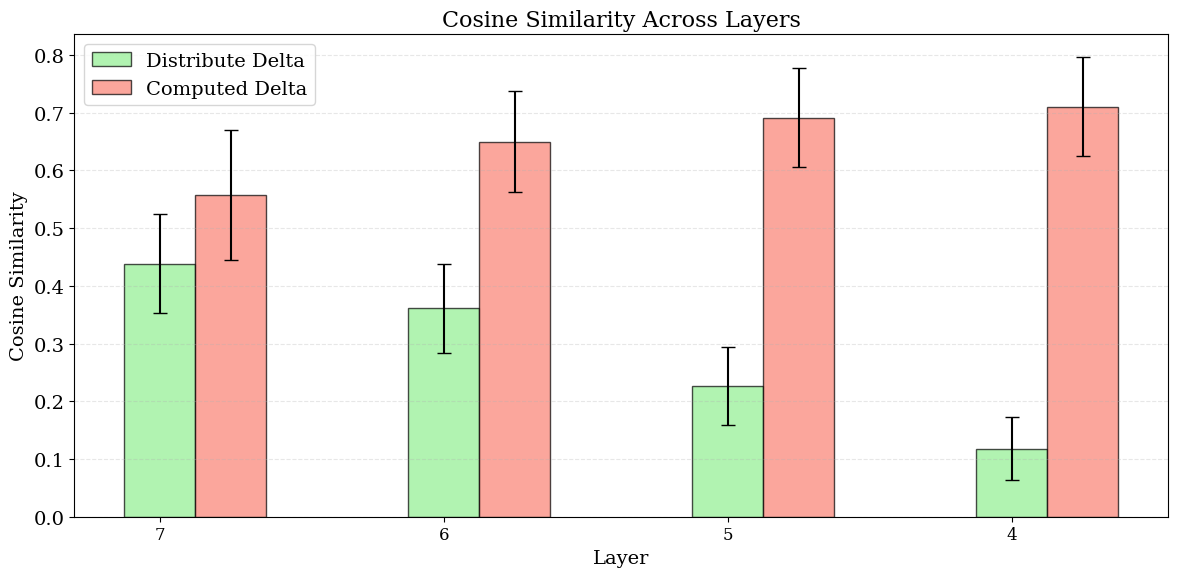

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 假设有三组cos_similarities数据
cos_similarities_1 = cos_similarities  # 第一组数据
cos_similarities_2 = distribute_norms  # 第二组数据
cos_similarities_3 = direct_norms # 第三组数据



# 合并所有数据
all_values_2_3 = []
for cos_sim in [cos_similarities_2, cos_similarities_3]:
    for values in cos_sim.values():
        all_values_2_3.extend(values)

# 将合并后的数据转换为 numpy 数组
all_values_2_3 = np.array(all_values_2_3)

# 获取合并数据的最小值和最大值（只考虑 cos_similarities_2 和 cos_similarities_3）
min_val_2_3 = np.min(all_values_2_3)
max_val_2_3 = np.max(all_values_2_3)

# 定义统一归一化函数
def normalize_data(data, min_val, max_val):
    normalized_data = {}
    for layer, values in data.items():
        values = np.array(values)
        # 统一归一化到 [0, 1] 范围
        normalized_data[layer] = (values - min_val) / (max_val - min_val)
    return normalized_data

# 对 cos_similarities_2 和 cos_similarities_3 进行统一归一化
cos_similarities_1_normalized = cos_similarities_1
cos_similarities_2_normalized = normalize_data(cos_similarities_2, min_val_2_3, max_val_2_3)
cos_similarities_3_normalized = normalize_data(cos_similarities_3, min_val_2_3, max_val_2_3)



# 提取各组数据的层、均值和标准差
layers = list(cos_similarities_1.keys())
means_1 = [np.mean(values) for values in cos_similarities_1_normalized.values()]
errors_1 = [np.std(values) for values in cos_similarities_1_normalized.values()]

means_2 = [np.mean(values) for values in cos_similarities_2_normalized.values()]
errors_2 = [np.std(values) for values in cos_similarities_2_normalized.values()]

means_3 = [np.mean(values) for values in cos_similarities_3_normalized.values()]
errors_3 = [np.std(values) for values in cos_similarities_3_normalized.values()]

# 反转顺序以确保从底层到上层显示
layers = layers[::-1]
means_1 = means_1[::-1]
errors_1 = errors_1[::-1]

means_2 = means_2[::-1]
errors_2 = errors_2[::-1]

means_3 = means_3[::-1]
errors_3 = errors_3[::-1]

# 设置图大小和字体
plt.rcParams.update({'font.size': 14})

# 设置柱状图宽度
bar_width = 0.25  # 调整条形宽度
x = np.arange(len(layers))  # 每个层的x位置

# 创建更宽敞的图形，增加图形宽度
plt.figure(figsize=(12, 6))

# 绘制带误差条的柱状图，增加条形之间的间距
# plt.bar(x - bar_width, means_1, width=bar_width, yerr=errors_1, capsize=5, 
#         color='skyblue', edgecolor='black', alpha=0.7, label='Cosine Similarity')
plt.bar(x, means_2, width=bar_width, capsize=5, yerr=errors_2,
        color='lightgreen', edgecolor='black', alpha=0.7, label='Distribute Delta')
plt.bar(x + bar_width, means_3, width=bar_width, capsize=5, yerr=errors_3,
        color='salmon', edgecolor='black', alpha=0.7, label='Computed Delta')

# 设置图形标签和标题
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
plt.title('Cosine Similarity Across Layers', fontsize=16)
plt.xticks(x, labels=layers, fontsize=12)  # 设置x轴刻度

# 添加水平网格线，使用更轻的颜色
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 显示图例，调整位置
plt.legend(loc='best')

# 调整布局并保存图片
plt.tight_layout()
plt.savefig("./figs/Llama3-mcf-cos-sim-multiple.pdf", dpi=300)
plt.show()

#### PCA visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LABELS = ["Optimized", "Spread"]

# 可视化函数
def plot_2d(data, labels, title):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = labels == label
        plt.scatter(data[idx, 0], data[idx, 1], label=f'{LABELS[label]}', alpha=0.7)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(loc='best', title=r"Residual")
    plt.grid(True)
    plt.show()


z_layer_deltas = np.vstack(layer_delta_dict[z_layer])
for layer in hparams.layers[:-1]:
    deltas = np.vstack(layer_delta_dict[layer])
    all_data = np.vstack([deltas, z_layer_deltas])
    labels = np.concatenate([[i] * len(layer_delta_dict[z_layer]) for i in range(2)])


    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(all_data)

    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    data_tsne = tsne.fit_transform(all_data)



    # 绘制 PCA 降维结果
    plot_2d(data_pca, labels, f"PCA Visualization, layer-{layer}")

    # plot_2d(data_tsne, labels, f"t-SNE Visualization, layer-{layer}")

### get HS

In [8]:
hs_dict = {layer: [] for layer in hparams.layers}

for i, layer in tqdm(enumerate(hparams.layers), total = len(hparams.layers)):
    hs = get_module_input_output_at_words(
            model,
            tok,
            layer,
            context_templates=[request["prompt"] for request in requests],
            words=[request["subject"] for request in requests],
            module_template=hparams.layer_module_tmp,
            fact_token_strategy=hparams.fact_token,
        )[1].T
    hs_dict[layer] = hs.cpu().detach().numpy()

with open('./pkls/hs_dict.pkl', 'wb') as f:
    pickle.dump(hs_dict, f)

 40%|████      | 2/5 [00:05<00:07,  2.58s/it]

100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


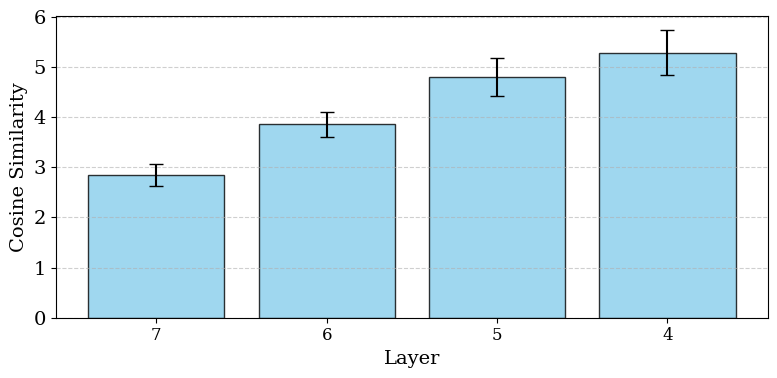

In [11]:
hs_norms = {layer: [] for layer in hparams.layers[:-1]}

last_layer_hs = hs_dict[8]
for i, layer in enumerate(hparams.layers[:-1]):
    hs_norms[layer] = np.linalg.norm(last_layer_hs - hs_dict[layer], axis=0).tolist()



plt.figure(figsize=(8, 4))  # 设置图大小 (宽, 高)
plt.rcParams.update({'font.size': 14})  # 全局字体大小

layers = list(hs_norms.keys())
means = [np.mean(values) for values in hs_norms.values()]
errors = [np.std(values) for values in hs_norms.values()]  # 误差为标准差

layers = layers[::-1]
means = means[::-1]
errors = errors[::-1]


# 绘制带误差条的柱状图
plt.bar(range(0,len(layers)), means, yerr=errors, capsize=5, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Cosine Similarity', fontsize=14)
# plt.title('Average Contribution Score with Error Bars')
plt.xticks(range(0,len(layers)), labels=layers, fontsize=12)  # 设置x轴刻度
plt.grid(axis='y', linestyle='--', alpha=0.6)  # 添加水平网格线
plt.tight_layout()
plt.show()

### Step Statistics

In [16]:
with open("./pkls/llama3_layer_steps_all.pkl", 'rb') as f:
    layer_steps_all = torch.load(f)

In [17]:
# layer_steps = {layer: [] for layer in [13, 14, 15, 16, 17]}
# for steps_all in layer_steps_all:
#     for key, value in steps_all.items():
#         layer_steps[key].extend(value)

for layer, steps in layer_steps_all.items():
    np_steps = np.array(steps)
    print(f"Layer: {layer}, steps-mean: {np_steps.mean()}, steps-std: {np_steps.std()}")

Layer: 4, steps-mean: 25.0, steps-std: 0.0
Layer: 5, steps-mean: 11.095, steps-std: 12.397821381194358
Layer: 6, steps-mean: 0.625, steps-std: 3.9031237489989987
Layer: 7, steps-mean: 0.0, steps-std: 0.0
Layer: 8, steps-mean: 0.0, steps-std: 0.0
